# Table of Content #

- [Importing Necessary Libraries](#Importing-Necessary-Libraries)
- [Importing Data and Initial Checks](#Importing-Data-and-Initial-Checks)
- [Pre-Processing](#Pre-Processing)
- [Baseline Classification Model](#Baseline-Classification-Model)

## Importing Necessary Libraries ##

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
                    
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Importing Data and Initial Checks ##

In [2]:
#Loading data from a csv file
data = pd.read_csv('~/ga/projects/capstone_data/data/data_model.csv')

#Checking size
data.shape

(1777932, 27)

In [3]:
#Checking columns
data.columns

Index(['Unnamed: 0', 'month', 'day_of_month', 'day_of_week', 'fl_date',
       'op_carrier', 'op_carrier_fl_num', 'origin', 'origin_city_name',
       'origin_state_abr', 'origin_state_nm', 'dest', 'dest_city_name',
       'dest_state_abr', 'dest_state_nm', 'dep_delay', 'arr_delay',
       'arr_del15', 'distance', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay', 'carrier', 'total_delay',
       'dep_hour'],
      dtype='object')

In [4]:
#Dropping a technical column
data.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)

## Pre-Processing

In order to prepare our dataset for modeling we need to know what features are heavily correlated with our target value.

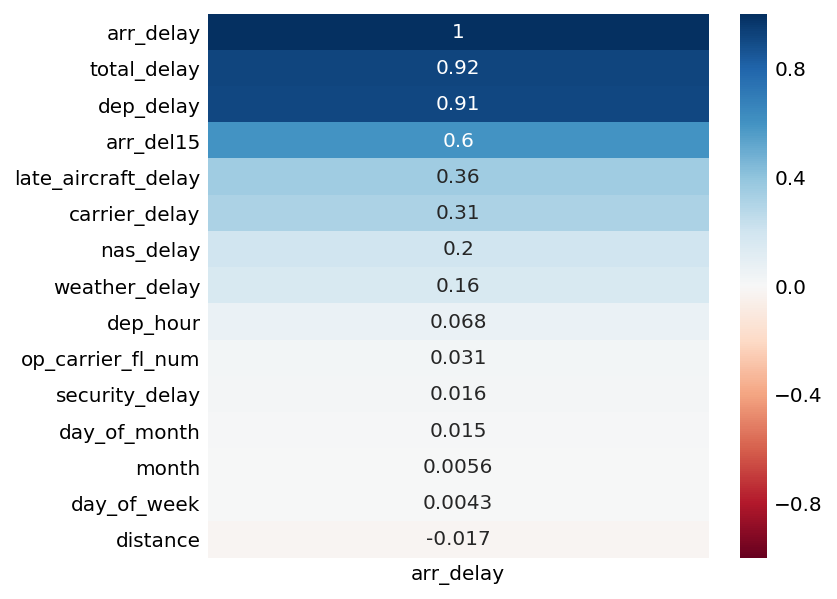

In [5]:
#Correlation heatmap to our target ARR_DELAY column
plt.figure(figsize = (5,5))
sns.heatmap(data.corr()[['arr_delay']].sort_values('arr_delay',ascending=False), 
            annot=True, 
            cmap = 'RdBu', 
            vmin = -1, vmax = 1);  

Looking at the correlation heatmap, one can notice a number of features that are heavily correlated to our target value:

* TOTAL_DELAY - which is an **explained** part of ARRIVAL_DELAY 
* DEP_DELAY
* LATE_AIRCRAFT_DELAY
* CARRIER_DELAY
* NAS_DELAY
* WEATHER_DELAY
* SECURITY_DELAY

These are integral parts of resulting delay on arrival and we could not use them for predicting the delay.

In [6]:
#Getting a list of delay column names
delay_columns = [column for column in data.columns if column.endswith('_delay')]

#Removing our target valuable 
delay_columns.remove('arr_delay')

#Dropping the delay_columns from the modeling dataset
data.drop(columns=delay_columns,axis=1,inplace=True)

In [7]:
#A look at our target - this is a possible regression target as a discrete variable 
data['arr_delay'].value_counts()

-10.0      52837
-9.0       52496
-11.0      52347
-8.0       52265
-7.0       51452
           ...  
 1112.0        1
 1576.0        1
 1556.0        1
 1008.0        1
 1213.0        1
Name: arr_delay, Length: 1325, dtype: int64

In [8]:
data['arr_delay'].describe()

count    1.777932e+06
mean     4.276324e+00
std      4.741508e+01
min     -7.400000e+01
25%     -1.400000e+01
50%     -6.000000e+00
75%      7.000000e+00
max      2.153000e+03
Name: arr_delay, dtype: float64

A discreet variable with a range between -7 and 2153, close to 2_000_000 values is not the best target variable for logistic regression. In our dataset we have a categorical variable ARR_DEL15 with the foloowing binary values:
* 0 - if ARRIVAL_DELAY is **less than 15 minutes** which corresponds with the industry standard when a "true delay" is considered to have happened and get reported accoringly when a flight arrives at a gate or disembarkation position 15 or more minutes later then scheduled
* 1 - if ARRIVAL_DELAY is **15 minutes or more - "true delay"**

This is our natural classification target variable. It's convenient to rename it and call a DELAY_INDICATOR.

In [9]:
#Renaming the column
data.rename(columns = {'arr_del15':'delay_indicator'}, inplace=True)

## Baseline Classification Model ##

In order to establish a basis for comparison, we need to set our baseline model and evaluation method. For classification models in our situation it is natural to opt for **accuracy** as we care for the accuracy of our predictions most, while sencitivity/specificity metrics and Type I/II errors are not of paramount importace. 

In [10]:
#Getting initial baseline accuracy
data['delay_indicator'].value_counts(normalize=True)

0.0    0.818503
1.0    0.181497
Name: delay_indicator, dtype: float64

In order to avoid inbalanced clasees with our future classification models we need to address this problem by constructing our modeling dataset in a way our positive and negative classes are balanced as 1:1. Hence, we will randomly pull flights out of our positive (flight on time) class - and a number of these flights will be equal to the number of observations in our negative (flight delayed) class. 

In [11]:
#Creating auxillary DataFrames with positive and negative classes and balancing the classes
data_negative = data[data['delay_indicator'] == 1]
data_pozitive = data[data['delay_indicator'] == 0].sample(data_negative.shape[0])

#Creating a balanced dataset for modeling
data_balanced = pd.concat([data_pozitive,data_negative])

#Checking the size of balanced dataset
data_balanced.shape

(644232, 19)

In [12]:
#Checking dataframe
data_balanced.head()

,month,day_of_month,day_of_week,fl_date,op_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_abr,origin_state_nm,dest,dest_city_name,dest_state_abr,dest_state_nm,arr_delay,delay_indicator,distance,carrier,dep_hour
768446,11,14,3,2018-11-14,AS,191,ANC,"Anchorage, AK",AK,Alaska,FAI,"Fairbanks, AK",AK,Alaska,-7.0,0.0,261.0,Alaska Airlines,9
1325116,12,31,1,2018-12-31,OO,4582,SHV,"Shreveport, LA",LA,Louisiana,ATL,"Atlanta, GA",GA,Georgia,-13.0,0.0,551.0,Delta,14
1164912,12,30,7,2018-12-30,DL,1685,ORF,"Norfolk, VA",VA,Virginia,ATL,"Atlanta, GA",GA,Georgia,-4.0,0.0,516.0,Delta,19
462837,10,31,3,2018-10-31,WN,1447,MCI,"Kansas City, MO",MO,Missouri,LAX,"Los Angeles, CA",CA,California,-27.0,0.0,1363.0,SouthWest,12
201091,10,2,2,2018-10-02,UA,465,MSN,"Madison, WI",WI,Wisconsin,DEN,"Denver, CO",CO,Colorado,-13.0,0.0,826.0,United,16


In [13]:
#Checking data types
data_balanced.dtypes

month                  int64
day_of_month           int64
day_of_week            int64
fl_date               object
op_carrier            object
op_carrier_fl_num      int64
origin                object
origin_city_name      object
origin_state_abr      object
origin_state_nm       object
dest                  object
dest_city_name        object
dest_state_abr        object
dest_state_nm         object
arr_delay            float64
delay_indicator      float64
distance             float64
carrier               object
dep_hour               int64
dtype: object

In [14]:
#Dropping columns with irrelevant/doubled information
data_balanced.drop(columns=['fl_date',
                           'op_carrier',
                           'origin_city_name',
                           'origin_state_abr',
                           'origin_state_nm',
                           'dest_city_name',
                           'dest_state_abr',
                           'dest_state_nm'], axis=1, inplace=True)

In [15]:
#Saving our pre-processed dataset to a csv file
data_balanced.to_csv('~/ga/projects/capstone_data/data/data_ready.csv')